<h1 align='center'> Image Classification using Deep Neural Networks(DNN) </h1>

In this notebook, I have explored use of deep neural networks(DNNs) i.e only linear layers for image classifications. I will be using PyTorch and Python as a backend implementation.

Here, I am using cattel breed dataset for traning and validation process. The dataset has mainly indian cattle breed images and the corresponding labels. There are around `26` distinct labels and original dataset size is around `3000`.

Our goal is to predict possible label for a given picture. 


**Here is a sample multilayer perceptrons for image classification tasks.**

<img src='../data/fully-connected-ltr.png' width="700" style="display: inline-block">

In our case we have *26* classes, so output layer should have size of *26*

## Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [1]:
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torch


## Load the Data

Images are stored in `Cattle_Resized` and inside that folder we have subfolders with name same as label name and it contains images corresponding to each image. 

PyTorch provides `torchvision.datasets.ImageFolder` functionality to load the images and it comes with different methods to get the class and it's index. It takes input as root path of image folder and the transformation if needed.


In [3]:
img_data = ImageFolder(root='../data/Cattle_Resized/')

*Get total length of the images*

In [4]:
data_size = len(img_data)

print(f"Total number of images {data_size}")

Total number of images 3056


We can also get images and it's labels. We can get `(img, label)` from a given index.

In [5]:
sample_img, sample_label = img_data[0]

sample_img, sample_label

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7FD8C9A50CD0>, 0)

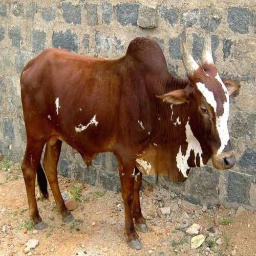

In [6]:
sample_img

`(sample_img, sample_label)` corresponds to a sample image of type `PIL.Image` and its `label` of type integer.

**Note** Label is nothing but index of sorted array of lables name like if we have two label's name `['cow', 'not cow']` => `sorted(['cow', 'not cow])` then label index is `[0, 1]` where `0` is index for `cow` and `1` is index of `not cow`. 

Since, the images are stored as `PIL.Image.Image` type we need to convert them into tensor before proceeding for modeling and traning. We can pass transform parameter as input to ImageFolder class itself. We can use `torchvision.transforms.ToTensor` to convert it into Tensors of pixels.

In [7]:
img_tensor_data = ImageFolder(root='../data/Cattle_Resized/', transform=transforms.ToTensor())

In [8]:
sample_img_tensor, sample_label = img_tensor_data[0]

In [9]:
#transform images into tensors
sample_img_tensor.view(1, -1)

tensor([[0.7333, 0.7686, 0.6549,  ..., 0.4235, 0.3922, 0.5059]])

In [10]:
sample_img_tensor.shape

torch.Size([3, 256, 256])

In above transformation, `transform.ToTensor()` converted image of type `PIL.Image.Image` type data into a matrix of size `nC*H*W` where `nC` is the number of channels, `H` is height of the image and `W` is the width of the image.

## Exploratory Data Analysis(EDA)

Let's explore basic EDA like total numbe of images, count for each label etc.

**Total numbe of images**

In [11]:
data_size = len(img_tensor_data)

print(f"Total number of images : {data_size}")

Total number of images : 3056


**Get all classe present in the cattle image dataste**

In [12]:
classes = img_tensor_data.classes

print(f"Classes in the dataset are : {', '.join(classes)}")

Classes in the dataset are : Alambadi Cow, Amritmahal Cow, Banni Buffalo, Bargur Cow, Dangi Cow, Deoni Cow, Gir Cow, Hallikar Cow, Jaffrabadi Buffalo, Kangayam Cow, Kankrej Cow, Kasaragod Cow, Kenkatha Cow, Kherigarh Cow, Malnad gidda Cow, Mehsana Buffalo, Nagori Cow, Nagpuri Buffalo, Nili ravi Buffalo, Nimari Cow, Pulikulam Cow, Rathi Cow, Sahiwal Cow, Shurti Buffalo, Tharparkar Cow, Umblachery Cow


**Distinct classes**

In [39]:
classes = img_tensor_data.classes

print(f"Distinct classes in the dataset : {len(classes)}")

Distinct classes in the dataset : 26


In the dataset we have different breeds of cows and buffalo.

**Size of Each Image**

In [13]:
img_tensor_data[0][0].squeeze().shape

torch.Size([3, 256, 256])

Images are of shape `256by256` and it has three color channels.

**Distribution of images per class**

In [14]:
label_count = {}

for img, label_idx in img_tensor_data:
    
    if label_idx not in label_count:
        label_count[label_idx] = 1
    else:
        label_count[label_idx] += 1

label_count
    

{0: 93,
 1: 95,
 2: 36,
 3: 60,
 4: 84,
 5: 103,
 6: 250,
 7: 186,
 8: 102,
 9: 116,
 10: 178,
 11: 95,
 12: 56,
 13: 36,
 14: 107,
 15: 96,
 16: 89,
 17: 220,
 18: 92,
 19: 87,
 20: 127,
 21: 148,
 22: 240,
 23: 60,
 24: 221,
 25: 79}

Let's get the original label name from the label indexes and plot it as a frequency chart.

In [15]:
class_count = {classes[i]:count for i, count in label_count.items()}

class_count

{'Alambadi Cow': 93,
 'Amritmahal Cow': 95,
 'Banni Buffalo': 36,
 'Bargur Cow': 60,
 'Dangi Cow': 84,
 'Deoni Cow': 103,
 'Gir Cow': 250,
 'Hallikar Cow': 186,
 'Jaffrabadi Buffalo': 102,
 'Kangayam Cow': 116,
 'Kankrej Cow': 178,
 'Kasaragod Cow': 95,
 'Kenkatha Cow': 56,
 'Kherigarh Cow': 36,
 'Malnad gidda Cow': 107,
 'Mehsana Buffalo': 96,
 'Nagori Cow': 89,
 'Nagpuri Buffalo': 220,
 'Nili ravi Buffalo': 92,
 'Nimari Cow': 87,
 'Pulikulam Cow': 127,
 'Rathi Cow': 148,
 'Sahiwal Cow': 240,
 'Shurti Buffalo': 60,
 'Tharparkar Cow': 221,
 'Umblachery Cow': 79}

Now we have class name and its instance count in our dataset.

**Plot the frequency chart**

In [16]:
#sort the class_count wrt to values
from collections import OrderedDict

class_count_sorted = dict(sorted(class_count.items(), key=lambda item: item[1], reverse=False))

class_count_sorted

{'Banni Buffalo': 36,
 'Kherigarh Cow': 36,
 'Kenkatha Cow': 56,
 'Bargur Cow': 60,
 'Shurti Buffalo': 60,
 'Umblachery Cow': 79,
 'Dangi Cow': 84,
 'Nimari Cow': 87,
 'Nagori Cow': 89,
 'Nili ravi Buffalo': 92,
 'Alambadi Cow': 93,
 'Amritmahal Cow': 95,
 'Kasaragod Cow': 95,
 'Mehsana Buffalo': 96,
 'Jaffrabadi Buffalo': 102,
 'Deoni Cow': 103,
 'Malnad gidda Cow': 107,
 'Kangayam Cow': 116,
 'Pulikulam Cow': 127,
 'Rathi Cow': 148,
 'Kankrej Cow': 178,
 'Hallikar Cow': 186,
 'Nagpuri Buffalo': 220,
 'Tharparkar Cow': 221,
 'Sahiwal Cow': 240,
 'Gir Cow': 250}

Text(0.5, 1.0, 'Frequency chart')

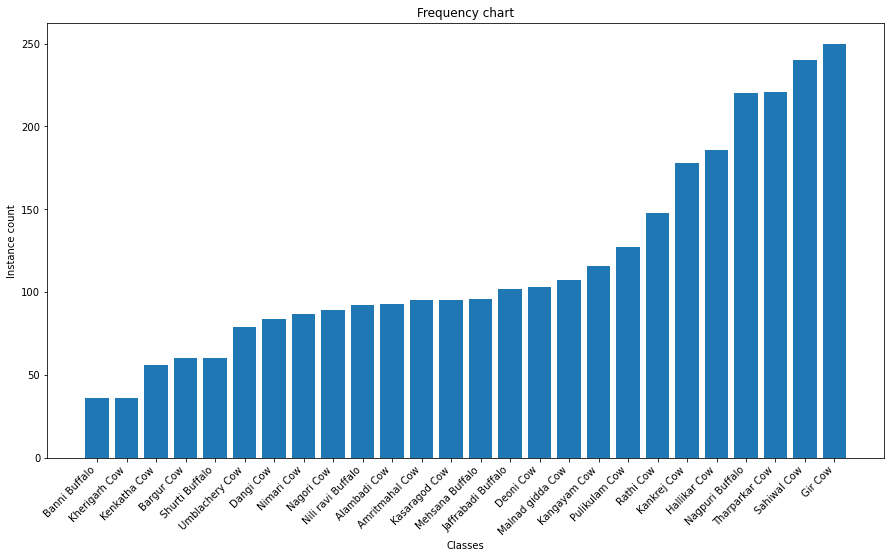

In [38]:
plt.figure(figsize=(15, 8))
plt.bar(class_count_sorted.keys(), class_count_sorted.values(), align='center')
#rotate xticks 
rotation_angle = 45 
plt.xticks(rotation=rotation_angle, ha='right')
plt.xlabel("Classes")
plt.ylabel("Instance count")
plt.title("Frequency chart")


From the above chart it is evident that the instance count of `Banni Buffalo` is minimum and for `Gir Cow` it is maximum.

**View sample image**

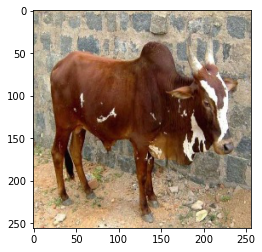

In [37]:
sample_img = img_tensor_data[0][0]
# Transpose dimensions 1, 2, and 0
transposed_img = sample_img.permute((1, 2, 0))  

plt.imshow(transposed_img, cmap='gist_yarg')
plt.show()


## Train and Test splits

We are done with preliminary investigation of our dataset. Now we can proceed for splitting our dataset into train and test set. Since the count of the classes are not equally distributed we can't just do normal split to get train and test set. We want equal representation of image instances from each class in our final train and test subset.

For split ratio we can divide out dataset into `80:20` train to test data size. The ratio should be on indiviudal class size like if `Banni Buffalo` has `36` instances in whole dataset then in traning set we will have `28` instances and test set will have `8` instances.

**Function for splitting data into train and test**

In [43]:
import random
from collections import defaultdict
from torch.utils.data import Subset


def train_test_split(dataset, test_split_fraction):
  
  '''

    `train_test_split` will split the dataset based on split  fraction and number of instances each class has
    input : dataset, split_fraction
    output : train and test dataset

  '''

  print("test split fraction : ",test_split_fraction)

  train_split_fraction = 1 - test_split_fraction

  #create a dict which will contains lables and corresponding indices in dataset
  label_to_indices = defaultdict(list)

  for idx, (img, label) in enumerate(dataset):

    label_to_indices[label].append(idx)
  print(label_to_indices.keys())  

  label_counts = [(label,len(indices)) for label,indices in label_to_indices.items()]
  #sort the labels with based on the instance count they have in dataset
  label_counts.sort(key = lambda x : x[1])
  print(label_counts)
  train_indices = []
  test_indices = []

  for label,count in label_counts:

    print(label,count)
    num_train = int(count*train_split_fraction)
    print("num train : ",num_train)
    train_indices.extend(random.sample(label_to_indices[label], num_train))
    test_indices.extend([idx for idx in [idx for idx in label_to_indices[label] if idx not in train_indices]])
  
  train = Subset(dataset,train_indices)
  print("train size : ",len(train))
  test = Subset(dataset, test_indices)
  print("test size : ",len(test))
  
  #append in dataloader
  return train, test

Call the above function to split the data.


In [44]:
cattle_data_train, cattle_data_test = train_test_split(img_tensor_data, 0.2)

test split fraction :  0.2
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25])
[(2, 36), (13, 36), (12, 56), (3, 60), (23, 60), (25, 79), (4, 84), (19, 87), (16, 89), (18, 92), (0, 93), (1, 95), (11, 95), (15, 96), (8, 102), (5, 103), (14, 107), (9, 116), (20, 127), (21, 148), (10, 178), (7, 186), (17, 220), (24, 221), (22, 240), (6, 250)]
2 36
num train :  28
13 36
num train :  28
12 56
num train :  44
3 60
num train :  48
23 60
num train :  48
25 79
num train :  63
4 84
num train :  67
19 87
num train :  69
16 89
num train :  71
18 92
num train :  73
0 93
num train :  74
1 95
num train :  76
11 95
num train :  76
15 96
num train :  76
8 102
num train :  81
5 103
num train :  82
14 107
num train :  85
9 116
num train :  92
20 127
num train :  101
21 148
num train :  118
10 178
num train :  142
7 186
num train :  148
17 220
num train :  176
24 221
num train :  176
22 240
num train :  192
6 250
num train :  200
train size :  2434
tes

### Batch loading

We have around `3000` records in the whole data. For any individual image if we flatten the imgae data we will have `256*256*3 = 196,608` incoming features, hidden layers of 200, 100, 50 and 10 output features. 

Total number of parameters we need to train if we include bias as well:

$\begin{align}\quad(196608\times200)+200+(200\times100)+100+(100\times50)+50+ (50\times10)+10&=\\
39321600+200+20000+100+5000+50+500+10 &= 39,347,460\end{align}$<br>

We have around `39.3M` parameters to train which is quite huge.

For this reason it makes sense to load training data in batches using <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader'><tt><strong>DataLoader</strong></tt></a>.

In [114]:
cattle_dataloader_train = DataLoader(cattle_data_train, batch_size=32, shuffle=True, drop_last=True)
cattle_dataloader_test = DataLoader(cattle_data_test, batch_size=32, shuffle=True, drop_last=True)

In [115]:
cattle_dataloader_train.batch_size

32

In the cell above, <tt><strong>cattle_dataloader_train</strong></tt> is a PyTorch <a href='https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset'><em>Dataset</em></a> object (an object that supports data loading and sampling).<br>
- The <tt><strong>batch_size</strong></tt> is the number of records to be processed at a time. If it's not evenly divisible into the dataset, then the final batch contains the remainder.<br>
- Setting <tt><strong>shuffle</strong></tt> to True means that the dataset will be shuffled after each epoch.
- Setting <tt><strong>drop_last</strong></tt> to True means that the if the last batch size is not equal to `32` then it will get dropped from the dataloader.

### View a batch of images

Once we've defined a DataLoader, we can create a grid of images using <a href='https://pytorch.org/docs/stable/torchvision/utils.html#torchvision.utils.make_grid'><tt><strong>torchvision.utils.make_grid</strong></tt></a>

Labels:  [  20    0   13   15    6    7   17   17    6    4    6    4]


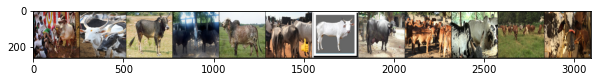

In [116]:
from torchvision.utils import make_grid
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}')) # to widen the printed array

# Grab the first batch of images
for images,labels in cattle_dataloader_train: 
    break
# Print the first 12 labels
print('Labels: ', labels[:12].numpy())

# Print the first 12 images
im = make_grid(images[:12], nrow=12)  
# the default nrow is 8
plt.figure(figsize=(10,10))
# We need to transpose the images from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

## Modeling

We are done with data splitting into train and test set and also we have packed the data into mini batches, now we can construct a model based on fully connected networks to classify the cattle breeds.


### Model Architecture: Multi-Layer Perceptron (MLP) for Image Classification

This neural network is designed to classify images into one of 26 classes. The input images have a size of 3x256x256 pixels, meaning they consist of three color channels (RGB) with a resolution of 256x256 pixels.

- **Input Layer:** The pixel values of the images are flattened into a single vector.

- **Hidden Layers:**
  1. **First Hidden Layer (200 neurons):** The flattened input is connected to a layer with 200 neurons. Each neuron applies a Rectified Linear Unit (ReLU) activation function, which captures non-linearity in the data. Dropout with a rate of 0.4 is applied, helping prevent overfitting by randomly deactivating neurons during training.
  
  2. **Second Hidden Layer (100 neurons):** The output from the first hidden layer is connected to another layer with 100 neurons. Similar to the first layer, ReLU activation and dropout are applied.
  
  3. **Third Hidden Layer (50 neurons):** The output from the second hidden layer is connected to a layer with 50 neurons. ReLU activation and dropout continue to be used for non-linearity and regularization.

- **Output Layer (26 neurons):** The final hidden layer's output is connected to an output layer with 26 neurons. Each neuron corresponds to one of the 26 classes that the model aims to classify. A softmax activation function is applied to convert the output values into probabilities, allowing the model to assign a likelihood to each class.

**Define the model**

In [117]:
import torch.nn.functional as F

In [136]:
class cattleBreedClassifier(nn.Module):

    def __init__(self, in_features=196608, out_features=26, layers=[200, 100, 50], p=0.4):
        super().__init__()

        layer_list = []
        for layer_sz in layers:

            layer_list.append(nn.Linear(in_features, layer_sz))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.Dropout1d(p))
            in_features = layer_sz

        
        #for last layer just add a linear one
        layer_list.append(nn.Linear(layers[-1], out_features))
        self.denseLayers = nn.Sequential(*layer_list)
    
    def forward(self, X):
        X = self.denseLayers(X)
        return F.log_softmax(X, dim=1)
    


In [137]:
torch.manual_seed(101)
model = cattleBreedClassifier()
model

cattleBreedClassifier(
  (denseLayers): Sequential(
    (0): Linear(in_features=196608, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout1d(p=0.4, inplace=False)
    (3): Linear(in_features=200, out_features=100, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout1d(p=0.4, inplace=False)
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout1d(p=0.4, inplace=False)
    (9): Linear(in_features=50, out_features=26, bias=True)
  )
)

**Count the model parameters**

In [138]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

In [139]:
count_parameters(model)

39321600
   200
 20000
   100
  5000
    50
  1300
    26
______
39348276


We have `39.3M` trainable parameters.

### Define loss function and optimizer

This is a classification problem so we will be using cross entropy loss as a main loss function and for optiming the loss function we are using Adam optimizer.

In [140]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### Model's Training

In each epoch, we will pass the test data through the model to evaluate its performance. This allows us to visualize both the loss and accuracy on the same plot.

<div class="alert alert-info"><strong>Important Note:</strong> In the section below labeled as <tt><em>#Count the number of correct predictions</em></tt>, we've included the following code snippet:
<pre style='background-color:rgb(217,100,247)'>
predicted = torch.max(y_pred.data, 1)[1]</pre>
This code snippet uses the <a href='https://pytorch.org/docs/stable/torch.html#torch.max'><tt><strong>torch.max()</strong></tt></a> function.

- The <tt>torch.max()</tt> function returns a tensor containing the maximum values along with a tensor of the corresponding indices where the maximum values were found. 
- In our code, we specifically request the index positions of the maximum values along dimension 1. This approach enables us to align predictions with image labels effectively.</div>

*For example*

In [141]:
torch.max(torch.FloatTensor([[1, 2, 3]]), 1)

torch.return_types.max(
values=tensor([3.]),
indices=tensor([2]))

**Traning loop**

In [142]:
for b, (X_train1, y_train) in enumerate(cattle_dataloader_train):
    pass

In [143]:
X_train1[0].shape

torch.Size([3, 256, 256])

In [144]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(cattle_dataloader_train):
       
        b+=1
        
        # Apply the model
        y_pred = model(X_train.view(32, -1))  # Here we flatten X_train
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%10 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{32*b:6}/2434]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(100*b):7.3f}%')
    
    # Update train loss & accuracy for the epoch
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(cattle_dataloader_test):

            # Apply the model
            y_val = model(X_test.view(32, -1))  # Here we flatten X_test

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
    
            # Update test loss & accuracy for the epoch
            loss = criterion(y_val, y_test)
            test_losses.append(loss)
            test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch:   10 [   320/2434]  loss: 7.85924816  accuracy:   0.600%
epoch:  0  batch:   20 [   640/2434]  loss: 5.63170528  accuracy:   1.000%
epoch:  0  batch:   30 [   960/2434]  loss: 8.48462200  accuracy:   0.933%
epoch:  0  batch:   40 [  1280/2434]  loss: 5.94488239  accuracy:   1.050%
epoch:  0  batch:   50 [  1600/2434]  loss: 3.76490307  accuracy:   1.020%
epoch:  0  batch:   60 [  1920/2434]  loss: 3.27716708  accuracy:   1.050%
epoch:  0  batch:   70 [  2240/2434]  loss: 3.23506236  accuracy:   1.100%
epoch:  1  batch:   10 [   320/2434]  loss: 3.24808383  accuracy:   1.900%
epoch:  1  batch:   20 [   640/2434]  loss: 3.23095679  accuracy:   2.000%
epoch:  1  batch:   30 [   960/2434]  loss: 3.21565413  accuracy:   2.000%
epoch:  1  batch:   40 [  1280/2434]  loss: 3.22800422  accuracy:   2.150%
epoch:  1  batch:   50 [  1600/2434]  loss: 3.23206329  accuracy:   2.180%
epoch:  1  batch:   60 [  1920/2434]  loss: 3.23749971  accuracy:   2.200%
epoch:  1  batch:   70 [ 

## Plot the loss

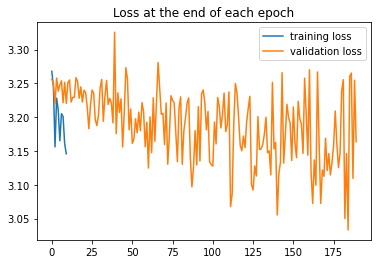

In [145]:
train_losses = [loss.item() for loss in train_losses]
test_losses = [loss.item() for loss in test_losses]
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

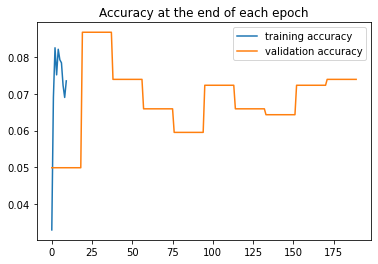

In [150]:
plt.plot([t/2434 for t in train_correct], label='training accuracy')
plt.plot([t/622 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend()

## Evaluation over test data

We retained the test scores during our training session:

In [153]:
# contains the results of all 10 epochs
print(test_correct) 
# print the most recent result as a percent
print(f'Test accuracy: {test_correct[-1].item()*100/622:.3f}%')

[tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(31), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(54), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(46), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(41), tensor(37), tensor(37), tensor(37), tensor(37), tensor(37), tensor(37), tensor(37), ten

However, we'd like to compare the predicted values to the ground truth (the y_test labels), so we'll run the test set through the trained model all at once.

In [154]:
# Extract the data all at once, not in batches
test_load_all = DataLoader(cattle_data_test, batch_size=622, shuffle=False)

In [155]:
with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))  
        # pass in a flattened view of X_test
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len(cattle_data_test)} = {correct.item()*100/(len(cattle_data_test)):7.3f}%')

Test accuracy: 48/622 =   7.717%


## Display the confusion matrix
This uses scikit-learn, and the predicted values obtained above.

In [157]:
from sklearn.metrics import confusion_matrix
# print a row of values for reference
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(26).reshape(1,26))
print()

# print the confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))

[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25]]

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [   1    1    0    0    0    1    1    2    2    1  

## Examine the misses
We can track the index positions of "missed" predictions, and extract the corresponding image and label. We'll do this in batches to save screen space.

In [158]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

574

In [159]:
# Display the first 10 index positions
misses

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
         44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
         55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
         66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
         77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
         88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
         99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
        110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
        121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
        132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
        143,  144,  145,  146,  147,  148,  149,  1

In [160]:
# Set up an iterator to feed batched rows
r = 12   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Now that everything is set up, run and re-run the cell below to view all of the missed predictions.

Index: [  48   49   50   51   52   53   54   55   56   57   58   59]
Label: [  23   23   23   23   25   25   25   25   25   25   25   25]
Guess: [  24   24   22    6   24   22   24   24    6   24    6   17]


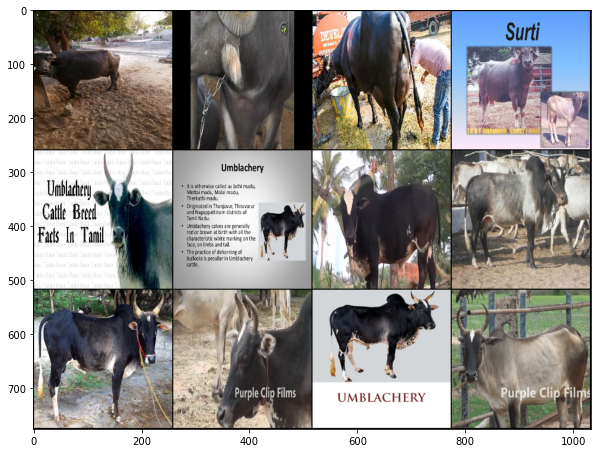

In [165]:
nextrow = next(row)
print("Index:", nextrow)
print("Label:", y_test.index_select(0,torch.tensor(nextrow)).numpy())
print("Guess:", predicted.index_select(0,torch.tensor(nextrow)).numpy())

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))